# 🎾 ATP Tennis Match Prediction
**Goal**: Predict match outcomes using pre-match features and Elo ratings.


In [1]:
import pandas as pd
import numpy as np
import glob
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
df = pd.read_csv(r"/content/all_atp_matches_merged.csv")
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1968-T101,Bombay,Clay,NaN,A,1967-12-28,106,100035,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-T102,Calcutta,NaN,NaN,A,1967-12-28,107,100035,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-T102,Calcutta,NaN,NaN,A,1967-12-28,106,110991,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-T102,Calcutta,NaN,NaN,A,1967-12-28,105,100035,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-T102,Calcutta,NaN,NaN,A,1967-12-28,104,100119,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 🧹 Step 1: Handle Missing and Invalid Data

Before calculating Elo or engineering features, we must ensure our dataset is clean.

- Remove rows with missing player IDs (`winner_id` or `loser_id`)
- Optionally, remove rows with invalid `tourney_date`
- Check for duplicate matches (if any)

---

## 🧠 Step 2: Calculate Elo Ratings

We dynamically track each player's Elo rating over time.

- Start all players with a base Elo (e.g., 1500)
- For each match, use pre-match Elo of both players
- Update Elo ratings after the result

This gives us 3 new features:
- `winner_pre_elo`
- `loser_pre_elo`
- `elo_diff`

---

## 🔧 Step 3: Basic Feature Engineering

We create useful pre-match features such as:

- `age_diff` = winner_age - loser_age
- `height_diff` = winner_ht - loser_ht
- `hand_diff` = 1 if hands differ, 0 if same
- `same_country` = 1 if both players have the same nationality

You can also later add:
- Rolling win rate
- Head-to-head record

---

## 🎯 Step 4: Create Target Variable

To train a machine learning model, we need a target:
- `label = 1` → if `winner_id` is assigned as Player 1
- `label = 0` → if `winner_id` is Player 2

We will randomly assign Player 1 and Player 2 in each match row for balance.


In [3]:
# 🧹 Step 1: Drop post-match columns
post_match_cols = [
    'score', 'minutes',
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
    'w_SvGms', 'w_bpSaved', 'w_bpFaced',
    'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon',
    'l_SvGms', 'l_bpSaved', 'l_bpFaced',
    'winner_rank_points', 'loser_rank_points'
]

df = df.drop(columns=[col for col in post_match_cols if col in df.columns])

# 🧹 Step 2: Basic cleaning
df['tourney_date'] = pd.to_datetime(df['tourney_date'], errors='coerce')
df = df.dropna(subset=['winner_id', 'loser_id', 'tourney_date'])
df = df.sort_values('tourney_date').reset_index(drop=True)
df = df.drop_duplicates()

# 🧠 Step 3: Elo rating system
K = 32
base_elo = 1500
elo_dict = defaultdict(lambda: base_elo)
elo_data = []

for _, row in df.iterrows():
    w_id = row['winner_id']
    l_id = row['loser_id']
    w_elo = elo_dict[w_id]
    l_elo = elo_dict[l_id]

    elo_data.append({
        'winner_pre_elo': w_elo,
        'loser_pre_elo': l_elo,
        'elo_diff': w_elo - l_elo
    })

    expected_w = 1 / (1 + 10 ** ((l_elo - w_elo) / 400))
    expected_l = 1 - expected_w

    elo_dict[w_id] += K * (1 - expected_w)
    elo_dict[l_id] += K * (0 - expected_l)

elo_df = pd.DataFrame(elo_data)
df = pd.concat([df.reset_index(drop=True), elo_df], axis=1)

# 🧪 Step 4: Feature engineering
df['age_diff'] = df['winner_age'] - df['loser_age']
df['height_diff'] = df['winner_ht'] - df['loser_ht']
df['hand_diff'] = (df['winner_hand'] != df['loser_hand']).astype(int)
df['same_country'] = (df['winner_ioc'] == df['loser_ioc']).astype(int)

# 🏷️ Step 5: Randomly assign Player 1 and Player 2 and define label
player_1_id = []
player_2_id = []
player_1_elo = []
player_2_elo = []
label = []

for _, row in df.iterrows():
    if random.random() > 0.5:
        player_1_id.append(row['winner_id'])
        player_2_id.append(row['loser_id'])
        player_1_elo.append(row['winner_pre_elo'])
        player_2_elo.append(row['loser_pre_elo'])
        label.append(1)
    else:
        player_1_id.append(row['loser_id'])
        player_2_id.append(row['winner_id'])
        player_1_elo.append(row['loser_pre_elo'])
        player_2_elo.append(row['winner_pre_elo'])
        label.append(0)

df['player_1_id'] = player_1_id
df['player_2_id'] = player_2_id
df['player_1_elo'] = player_1_elo
df['player_2_elo'] = player_2_elo
df['elo_diff_p1'] = df['player_1_elo'] - df['player_2_elo']
df['label'] = label

# 💾 Step 6: Save the processed dataset
df.to_csv("cleaned_with_elo_features.csv", index=False)
print("✅ Dataset saved as 'cleaned_with_elo_features.csv'")


✅ Dataset saved as 'cleaned_with_elo_features.csv'


## 🎯 Elo Rating System for Tennis Matches

The Elo rating system is a powerful way to estimate a player's strength based on past performance. Originally developed for chess, it's widely used in sports analytics — including tennis.

### 📌 Why Use Elo Ratings?
- **Dynamic player strength**: Unlike static rankings, Elo updates after each match
- **No manual feature design**: The formula reflects recent performance, opponent difficulty, and upsets
- **Great predictor**: Used in models to capture form and skill difference

### ⚙️ How Elo Works:
Each player starts with a base rating (e.g., 1500). When two players compete:

1. Calculate **expected win probability** for each:
   \[
   E_A = \frac{1}{1 + 10^{(R_B - R_A)/400}}
   \]

2. Update winner's rating:
   \[
   R'_A = R_A + K \cdot (1 - E_A)
   \]
   And similarly for the loser:
   \[
   R'_B = R_B + K \cdot (0 - E_B)
   \]

- **K-factor** controls how fast ratings change (typically 32–40)
- A win against a higher-rated opponent increases Elo more

We'll now compute Elo ratings for each player **before** their match and add them as features.


In [4]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,age_diff,height_diff,hand_diff,same_country,player_1_id,player_2_id,player_1_elo,player_2_elo,elo_diff_p1,label
0,1968-T101,Bombay,Clay,NaN,A,1967-12-28,106,100035,NaN,NaN,...,1.5,NaN,0,0,100035,100051,1500.0,1500.0,0.0,1
1,1968-T101,Bombay,Clay,NaN,A,1967-12-28,103,100051,NaN,NaN,...,5.7,NaN,0,0,100119,100051,1500.0,1484.0,16.0,0
2,1968-T101,Bombay,Clay,NaN,A,1967-12-28,101,100092,NaN,NaN,...,1.3,NaN,0,0,100113,100092,1500.0,1500.0,0.0,0
3,1968-T101,Bombay,Clay,NaN,A,1967-12-28,102,110991,NaN,NaN,...,0.4,NaN,0,0,110991,100070,1500.0,1500.0,0.0,1
4,1968-T101,Bombay,Clay,NaN,A,1967-12-28,105,100092,NaN,NaN,...,-2.5,NaN,0,0,100092,110991,1516.0,1516.0,0.0,1


🧠 Optional Advanced Features (Later)
If you want to improve performance after your first model, you could add:

| Feature Idea             | Description                         |
|--------------------------|-------------------------------------|
| 🧮 Rolling Win Rate      | Win % over past N matches           |
| 🔁 Head-to-head record   | Wins vs same opponent               |
| 📆 Match count in last 30 days | For fatigue modeling              |
| 🌍 Country/home court    | Home advantage binary               |
| 🧠 Surface-specific Elo | Separate Elo per surface (Clay, Hard, Grass) |

But for now — no need to add more. Let's train a basic model first and evaluate it!

In [5]:
# 🧠 Step 1: Select Features & Target (only meaningful pre-match features)

features = [
    'player_1_elo',
    'player_2_elo',
    'elo_diff_p1',
    'age_diff',
    'height_diff',
    'hand_diff',
    'same_country'
]

# Drop rows with any missing values in the selected features
df_cleaned = df.dropna(subset=features).copy()

X = df_cleaned[features]
y = df_cleaned['label']

from sklearn.model_selection import train_test_split

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression

# Train model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

print("Model trained successfully!")

Model trained successfully!


In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"🔍 Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Full Report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

🔍 Accuracy: 0.6684

📊 Confusion Matrix:
[[10501  5402]
 [ 5185 10840]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.66     15903
           1       0.67      0.68      0.67     16025

    accuracy                           0.67     31928
   macro avg       0.67      0.67      0.67     31928
weighted avg       0.67      0.67      0.67     31928



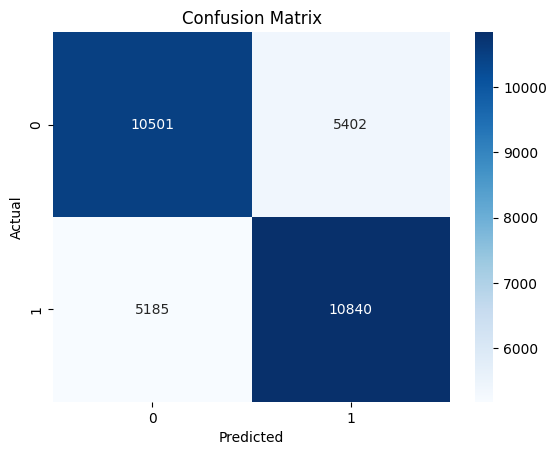

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Advance Models

from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.6715422199949888
[[10513  5390]
 [ 5097 10928]]
              precision    recall  f1-score   support

           0       0.67      0.66      0.67     15903
           1       0.67      0.68      0.68     16025

    accuracy                           0.67     31928
   macro avg       0.67      0.67      0.67     31928
weighted avg       0.67      0.67      0.67     31928



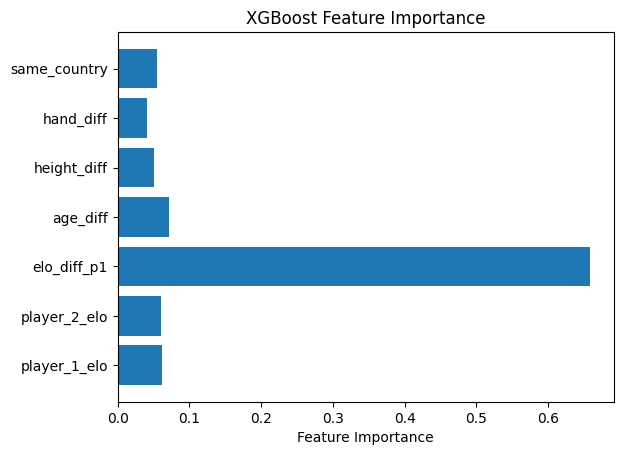

In [10]:
# Tracking Feature importance

import matplotlib.pyplot as plt

importances = xgb.feature_importances_
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()